In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle

In [4]:
!kaggle datasets download -d kaustubhb999/tomatoleaf

 96% 172M/179M [00:01<00:00, 107MB/s]
100% 179M/179M [00:01<00:00, 109MB/s]


In [5]:
!unzip /content/tomatoleaf.zip

Streaming output truncated to the last 5000 lines.
  inflating: tomato/train/Tomato___Target_Spot/002213fb-b620-4593-b9ac-6a6cc119b100___Com.G_TgS_FL 8360.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0044d10f-7062-4655-8abd-9fffc5b2f152___Com.G_TgS_FL 7908.JPG  
  inflating: tomato/train/Tomato___Target_Spot/00854623-ba28-446d-a1d5-03c0ae3f99d9___Com.G_TgS_FL 7949.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0118c27a-f34a-41e1-8b2f-d2c564f83c5c___Com.G_TgS_FL 0013.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0118ed61-b135-45be-ad81-7e2d54203be4___Com.G_TgS_FL 8241.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0197df47-a9cb-4b6c-b72c-ac0e9af6d135___Com.G_TgS_FL 0779.JPG  
  inflating: tomato/train/Tomato___Target_Spot/025510ac-15db-4861-b02b-21da82161100___Com.G_TgS_FL 0952.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0288164e-d6cf-4215-b593-7b581308a4cf___Com.G_TgS_FL 9777.JPG  
  inflating: tomato/train/Tomato___Target_Spot/03002b91-afe3-4c72-86b

In [6]:
#Import Required Libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [7]:
# Define paths for train, validation, and test data
train_data_dir='/content/tomato/train'
val_data_dir='/content/tomato/val'

Training Directory Image Counts:
Tomato___healthy: 1000
Tomato___Late_blight: 1000
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1000
Tomato___Bacterial_spot: 1000
Tomato___Early_blight: 1000
Tomato___Tomato_mosaic_virus: 1000
Tomato___Target_Spot: 1000
Tomato___Leaf_Mold: 1000
Tomato___Spider_mites Two-spotted_spider_mite: 1000
Tomato___Septoria_leaf_spot: 1000


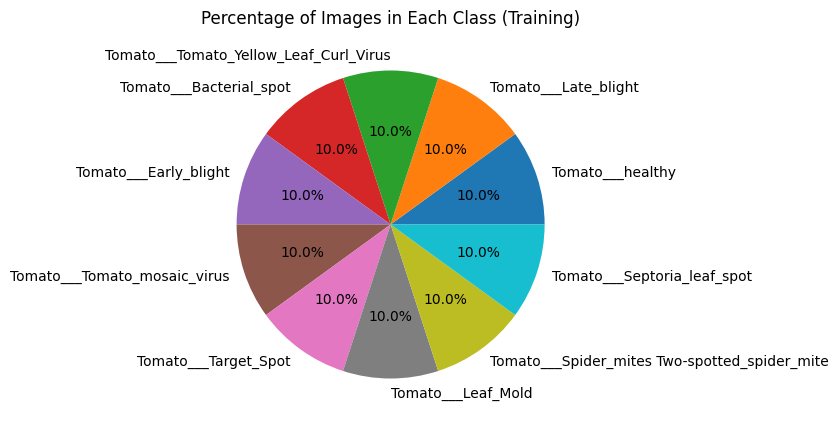

In [27]:
# Function to count images in each class
def count_images_in_directory(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_class_counts = count_images_in_directory(train_data_dir)
val_class_counts = count_images_in_directory(val_data_dir)
print("Training Directory Image Counts:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count}")
# Plotting the pie chart for training data
plt.figure(figsize=(5,5))
plt.pie(train_class_counts.values(), labels=train_class_counts.keys(), autopct='%1.1f%%')
plt.title('Percentage of Images in Each Class (Training)')
plt.show()

Validation and Test Directory Image Counts:
Tomato___healthy: 100
Tomato___Late_blight: 100
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 100
Tomato___Bacterial_spot: 100
Tomato___Early_blight: 100
Tomato___Tomato_mosaic_virus: 100
Tomato___Target_Spot: 100
Tomato___Leaf_Mold: 100
Tomato___Spider_mites Two-spotted_spider_mite: 100
Tomato___Septoria_leaf_spot: 100


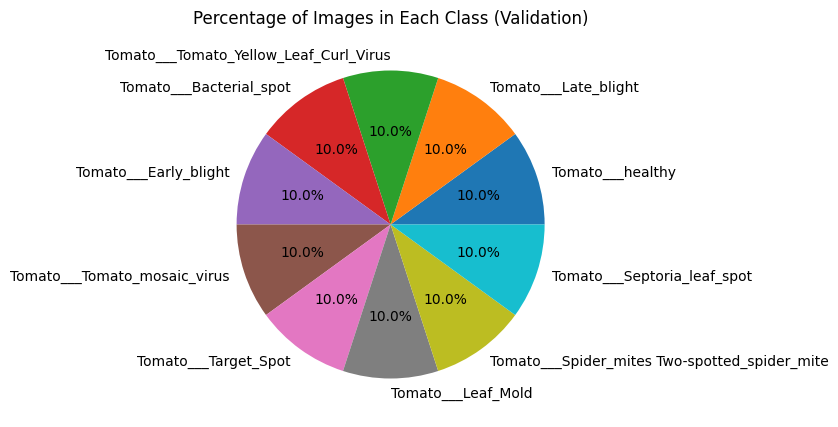

In [35]:
print("Validation and Test Directory Image Counts:")
for class_name, count in val_class_counts.items():
    print(f"{class_name}: {count}")
# Plotting the pie chart for validation data
plt.figure(figsize=(5,5))
plt.pie(val_class_counts.values(), labels=val_class_counts.keys(), autopct='%1.1f%%')
plt.title('Percentage of Images in Each Class (Validation)')
plt.show()

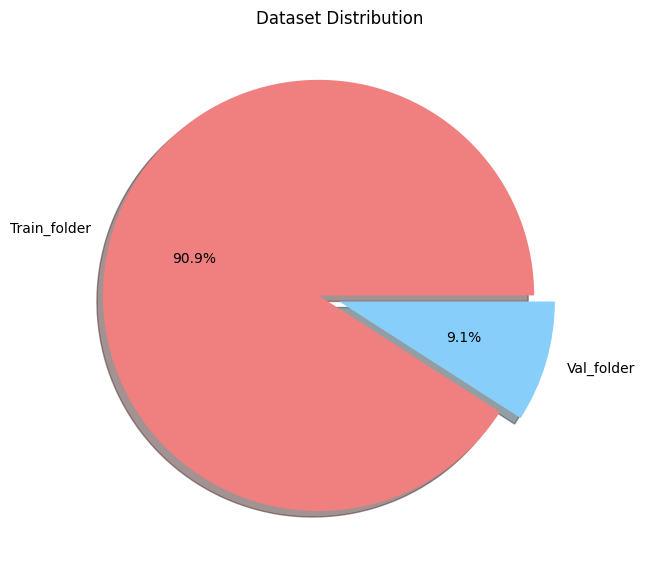

In [11]:
# Get the list of subdirectories (class folders) in the train_data_dir
train_subdirectories = next(os.walk(train_data_dir))[1]
# Calculate the total number of images in all subdirectories
train_total_images = sum(len(os.listdir(os.path.join(train_data_dir, subdir))) for subdir in train_subdirectories)
# Get the list of subdirectories (class folders) in the val_data_dir
val_subdirectories = next(os.walk(val_data_dir))[1]
# Calculate the total number of images in all subdirectories
val_total_images = sum(len(os.listdir(os.path.join(val_data_dir, subdir))) for subdir in val_subdirectories)
# Create pie chart for dataset distribution
sizes = [train_total_images,val_total_images]
labels = ['Train_folder',  'Val_folder']
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice
plt.figure(figsize=(7, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True)
plt.title('Dataset Distribution')
plt.show()

In [12]:
# Set hyperparameters
batch_size = 32
epochs = 20

In [13]:
# Define class ordering based on the assumption of 10 classes for tomato diseases
class_order = [
    'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy',
    'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
    'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
]

In [28]:
# Data generator with rescaling only for train, validation, and test data
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,vertical_flip=True,fill_mode='nearest')

In [29]:
# Create data generator for training data with class ordering
train_generator = datagen.flow_from_directory(train_data_dir,target_size=(256, 256),batch_size=batch_size,class_mode='categorical',classes=class_order,seed=123)
# Create data generator for validation data with class ordering
val_generator = datagen.flow_from_directory(val_data_dir,target_size=(256, 256),batch_size=batch_size,class_mode='categorical',classes=class_order,shuffle=False)
# Create data generator for test data with class ordering
test_generator = datagen.flow_from_directory(val_data_dir,target_size=(256, 256),batch_size=batch_size,class_mode='categorical',classes=class_order,shuffle=False)

Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


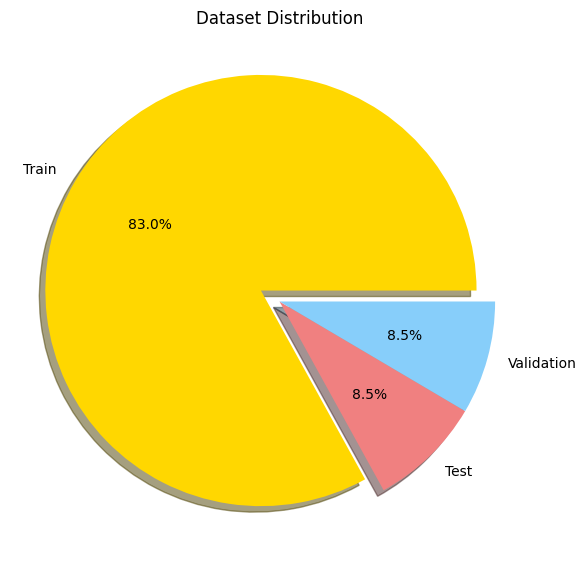

In [30]:
# Create pie chart for dataset distribution
sizes = [len(train_generator), len(test_generator), len(val_generator)]
labels = ['Train', 'Test', 'Validation']
colors = ['gold', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0)  # explode 1st slice
plt.figure(figsize=(7, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True)
plt.title('Dataset Distribution')
plt.show()

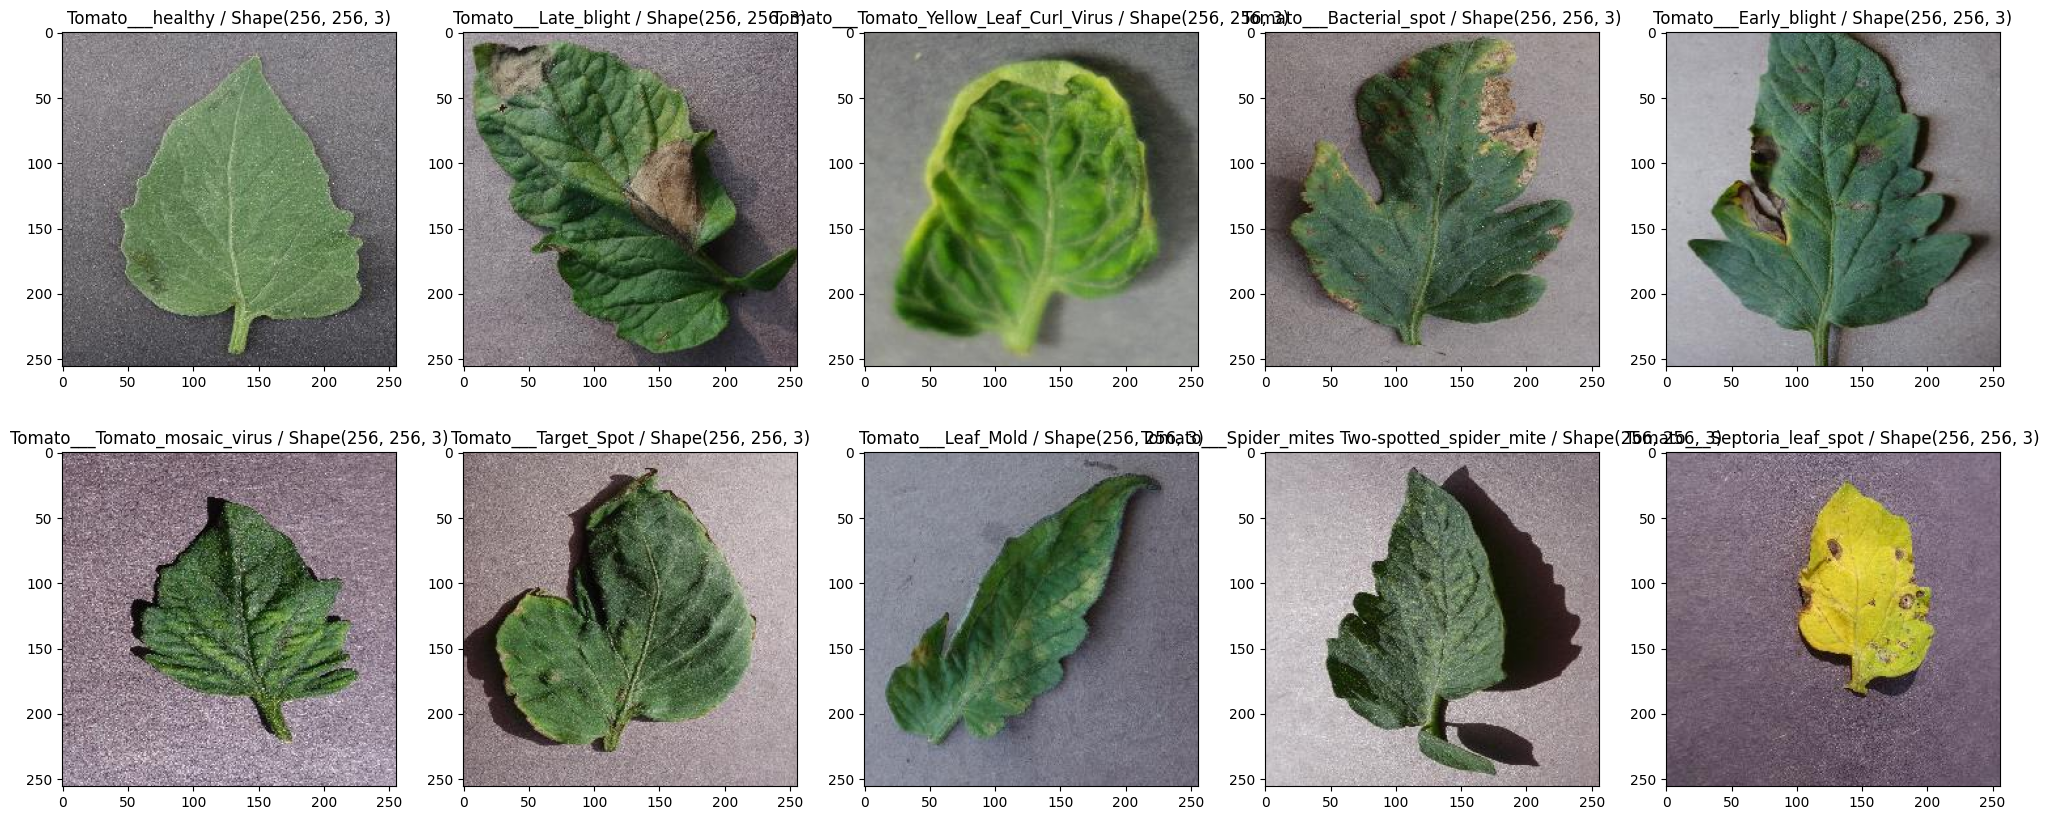

In [31]:
# Plot sample images from each class in the training data
classes = os.listdir(train_data_dir)
plt.figure(figsize=(25, 10))

for i, class_name in enumerate(classes):
    class_path = os.path.join(train_data_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        if images:
            pic = os.path.join(class_path, images[0])
            image = Image.open(pic)
            image = np.asarray(image)
            plt.subplot(2, 5, i+1)
            plt.title('{0} / Shape{1}'.format(class_name, image.shape))
            plt.imshow(image)

plt.show()

In [32]:
# Load pre-trained ResNet152V2 model
base_model = ResNet152V2(weights='imagenet', include_top=False)
# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

234545216/234545216 [==============================] - 1s 0us/step


In [36]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_order), activation='softmax')(x)  # Use len(class_order) for number of classes

In [37]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [38]:
# Getting summary of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, None, None, 64)       0         ['conv1_conv[0][0]']          
                                                                                            

In [39]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
# Train the model
history=model.fit(train_generator,steps_per_epoch=len(train_generator),epochs=epochs,validation_data=val_generator,validation_steps=len(val_generator))

Epoch 1/20
313/313 [==============================] - 221s 658ms/step - loss: 0.8570 - accuracy: 0.7198 - val_loss: 0.6585 - val_accuracy: 0.7830
Epoch 2/20
313/313 [==============================] - 198s 634ms/step - loss: 0.5104 - accuracy: 0.8266 - val_loss: 0.4563 - val_accuracy: 0.8440
Epoch 3/20
313/313 [==============================] - 200s 638ms/step - loss: 0.4000 - accuracy: 0.8637 - val_loss: 0.4771 - val_accuracy: 0.8330
Epoch 4/20
313/313 [==============================] - 201s 643ms/step - loss: 0.3632 - accuracy: 0.8745 - val_loss: 0.4155 - val_accuracy: 0.8480
Epoch 5/20
313/313 [==============================] - 201s 640ms/step - loss: 0.3164 - accuracy: 0.8898 - val_loss: 0.3635 - val_accuracy: 0.8730
Epoch 6/20
313/313 [==============================] - 197s 628ms/step - loss: 0.3054 - accuracy: 0.8941 - val_loss: 0.3394 - val_accuracy: 0.8810
Epoch 7/20
313/313 [==============================] - 200s 637ms/step - loss: 0.2978 - accuracy: 0.8957 - val_loss: 0.3458 -

In [41]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

32/32 [==============================] - 18s 548ms/step - loss: 0.2918 - accuracy: 0.9110
Test Loss: 0.29177922010421753, Test Accuracy: 0.9110000133514404


1/1 [==============================] - 0s 30ms/step


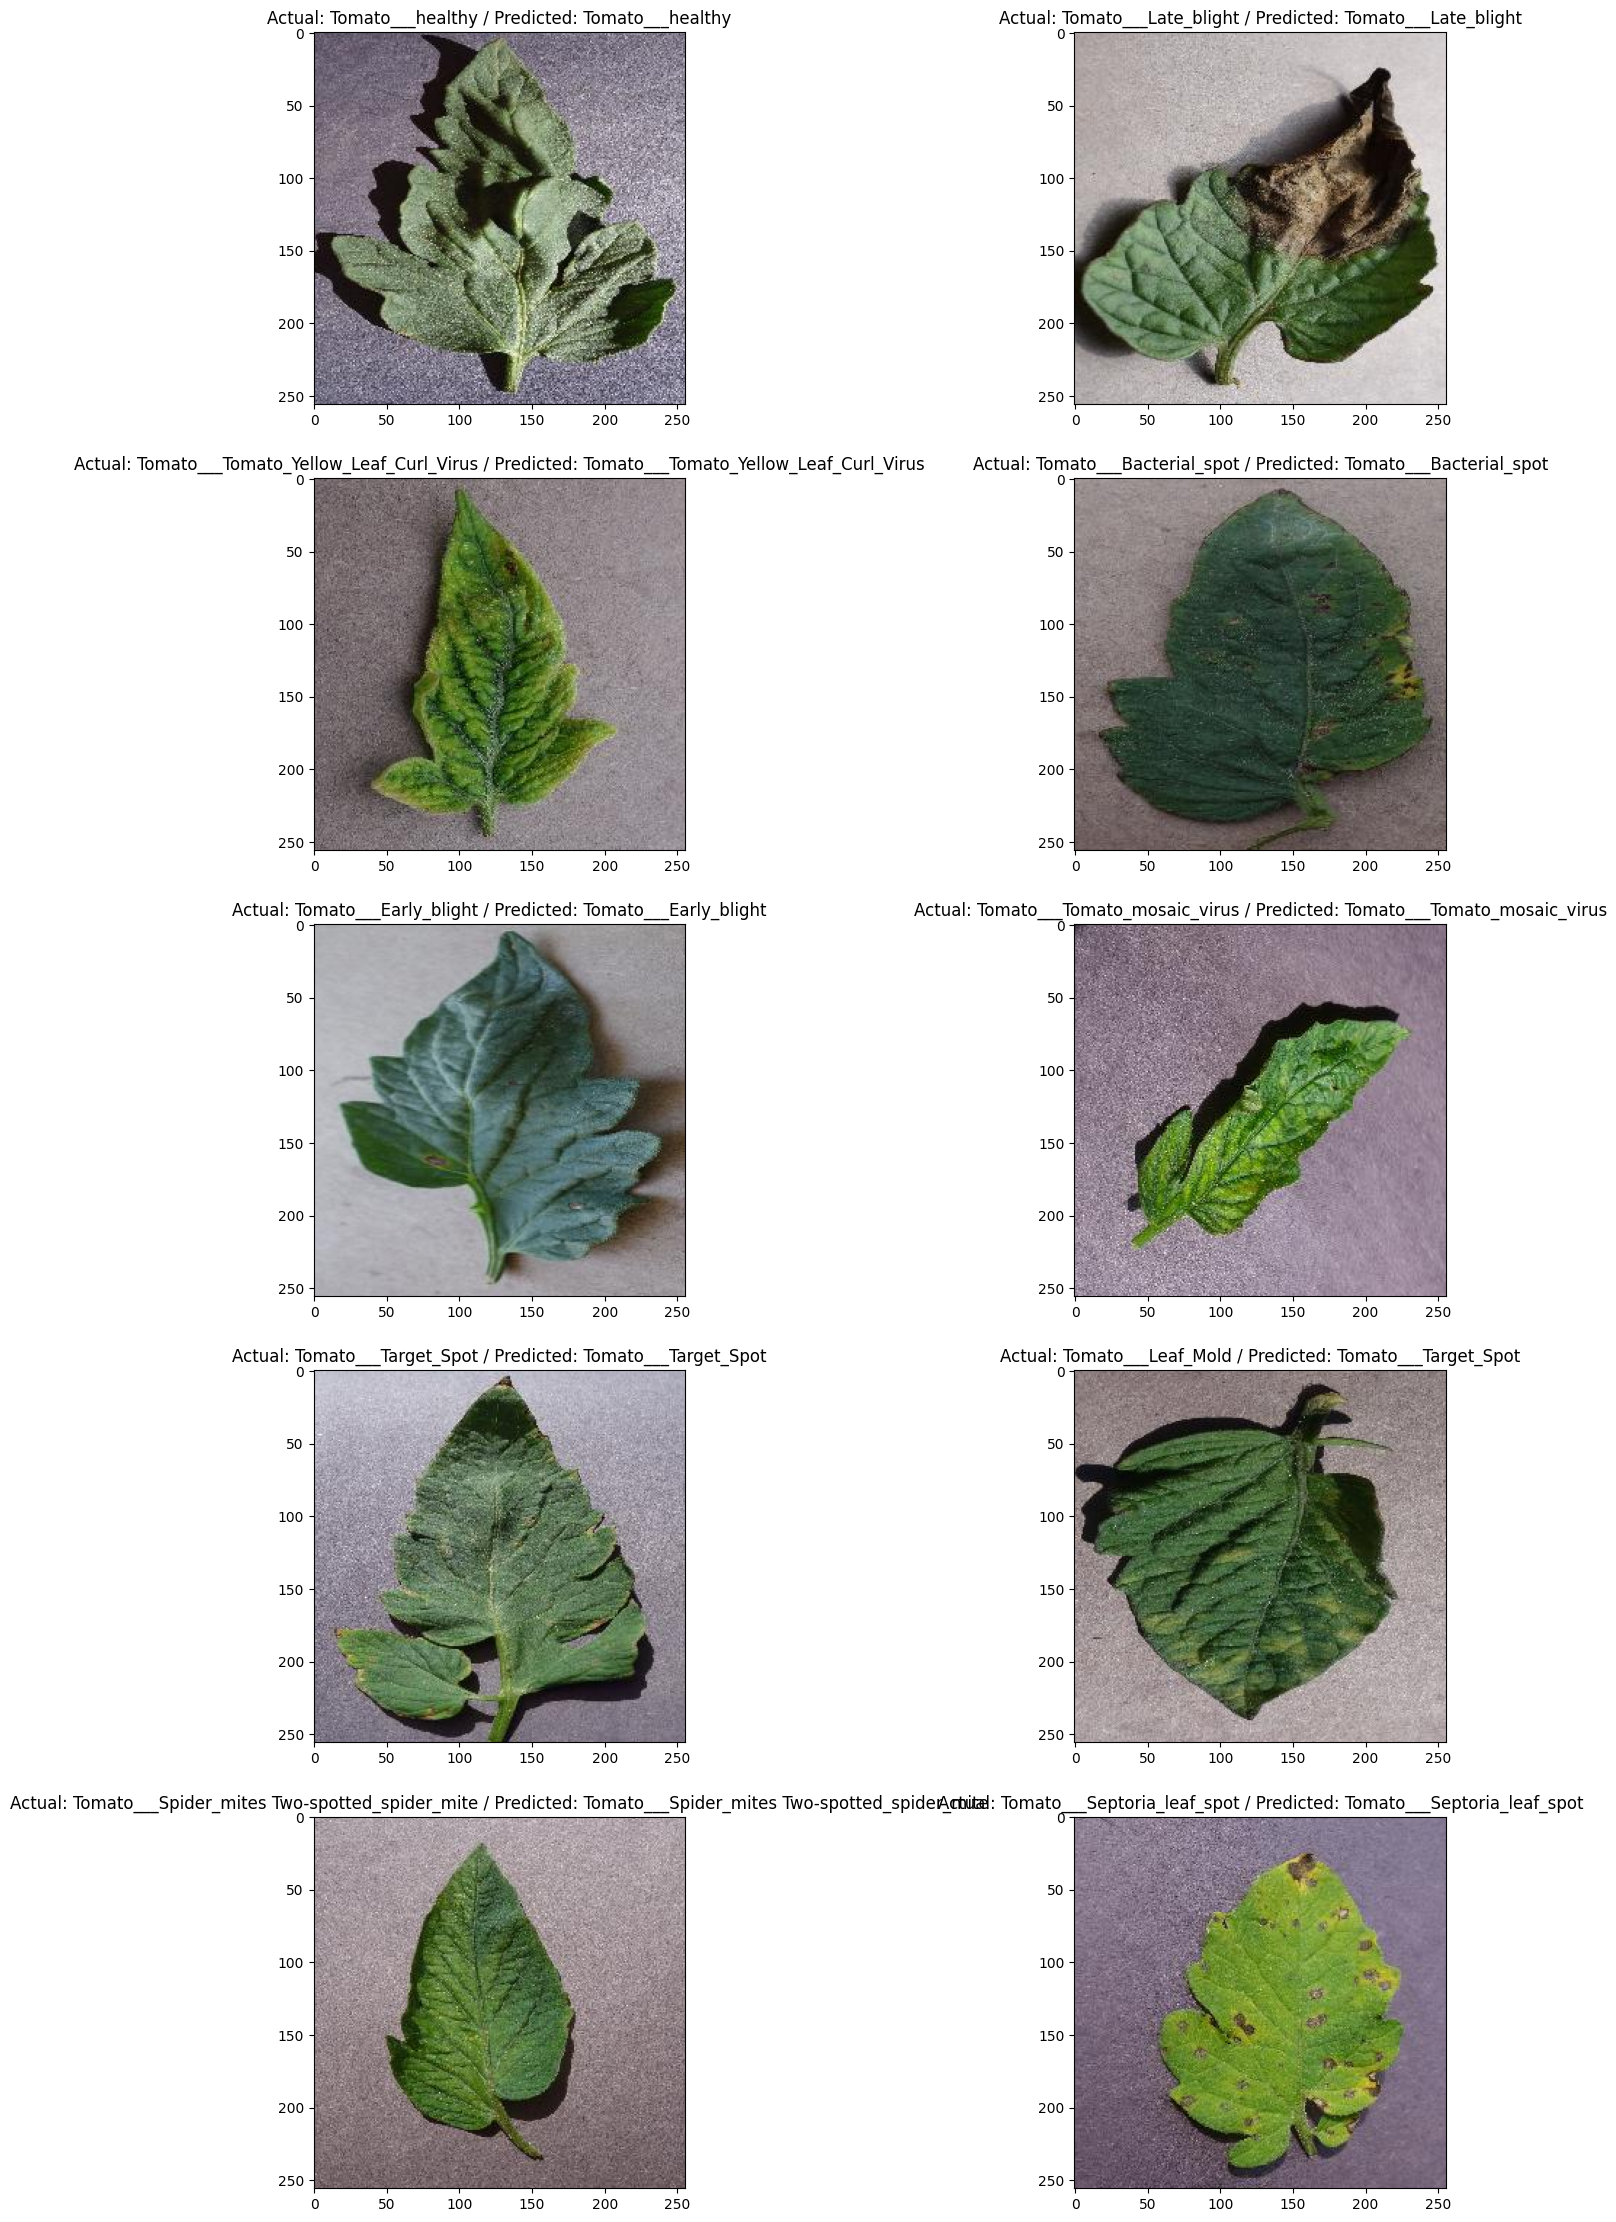

In [42]:
# Prediction and visualizations for validation data
classes = os.listdir(val_data_dir)
plt.figure(figsize=(18, 28))

for i, class_name in enumerate(classes):
    pic_list = os.listdir(os.path.join(val_data_dir, class_name))
    pic = pic_list[np.random.randint(len(pic_list))]
    image = Image.open(os.path.join(val_data_dir, class_name, pic))
    image = np.asarray(image)
    pred = np.argmax(model.predict(image.reshape(-1, 256, 256, 3) / 255))
    prediction = class_order[pred]
    plt.subplot(5, 2, i+1)
    plt.title('Actual: {0} / Predicted: {1}'.format(class_name, prediction))
    plt.imshow(image)

plt.show()

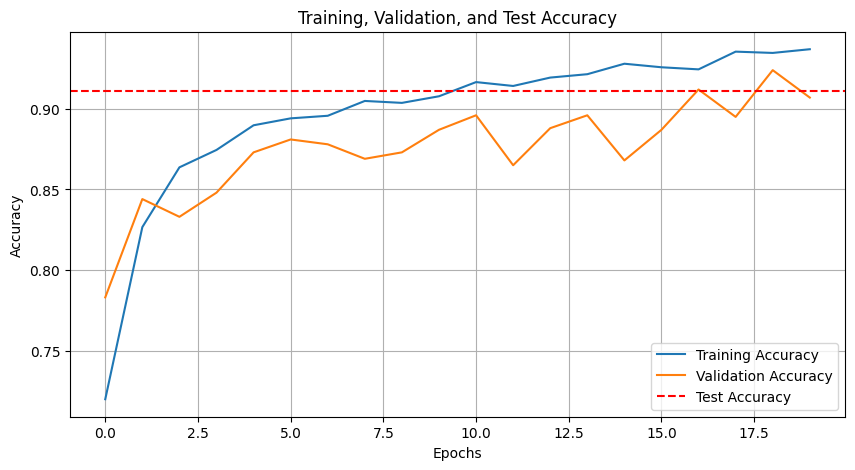

In [43]:
# Plotting accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.grid()
plt.show()

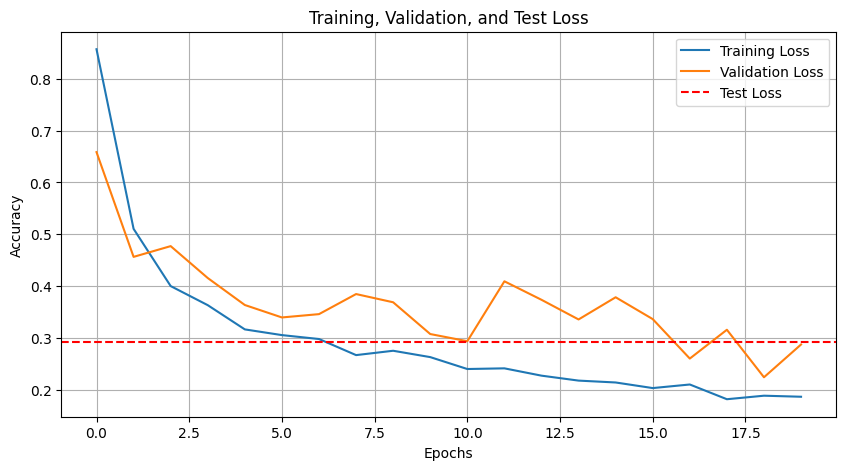

In [45]:
# Plotting accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.grid()
plt.show()

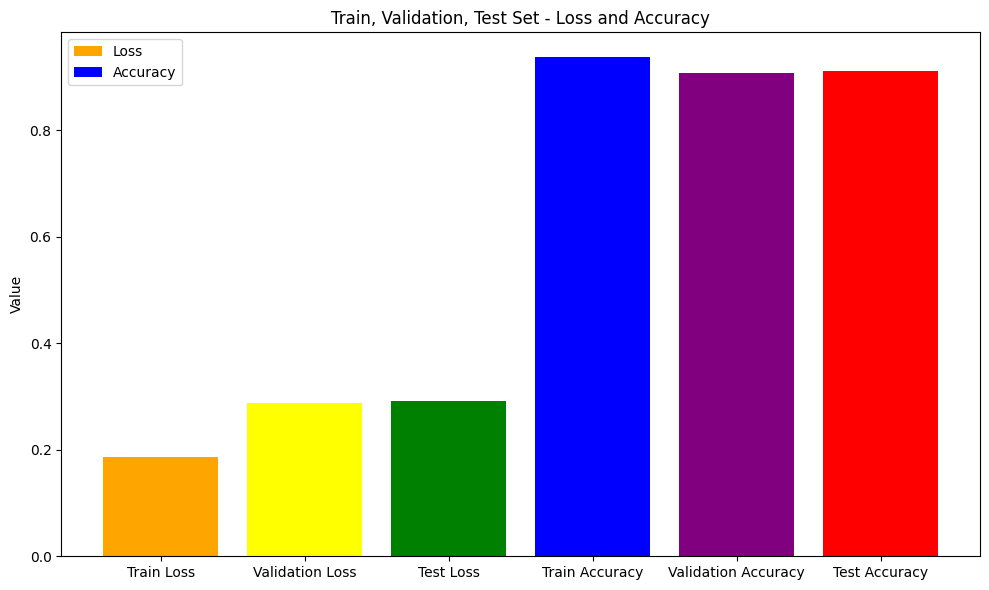

In [81]:
loss = history.history['loss'][-1]  # Final training loss
val_loss = history.history['val_loss'][-1]  # Final validation loss
accuracy = history.history['accuracy'][-1]  # Final training accuracy
val_accuracy = history.history['val_accuracy'][-1]  # Final validation accuracy
# Create a bar plot for train, validation, and test set loss and accuracy
plt.figure(figsize=(10, 6))
# Loss bars
plt.bar(['Train Loss', 'Validation Loss', 'Test Loss'], [loss, val_loss, test_loss], color=['orange', 'yellow', 'green'], label='Loss')
# Accuracy bars
plt.bar(['Train Accuracy', 'Validation Accuracy', 'Test Accuracy'], [accuracy, val_accuracy, test_accuracy], color=['blue', 'purple', 'red'], label='Accuracy')
plt.title('Train, Validation, Test Set - Loss and Accuracy')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

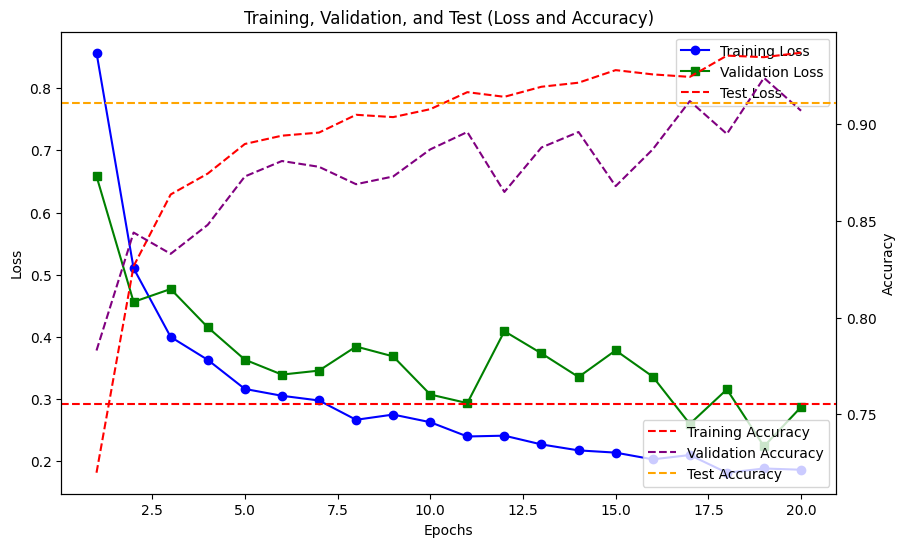

In [48]:
# accuracy and loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
test_loss = test_loss  # Replace test_loss with the actual value
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
test_accuracy = test_accuracy  # Replace test_accuracy with the actual value
epochs = range(1, len(train_loss) + 1)  # Epoch numbers

# Create a figure and axis for subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot training, validation, and test loss on the first y-axis
ax1.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
ax1.plot(epochs, val_loss, label='Validation Loss', color='green', marker='s')
ax1.axhline(y=test_loss, color='red', linestyle='--', label='Test Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training, Validation, and Test (Loss and Accuracy)')
ax1.legend(loc='upper right')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.plot(epochs, train_accuracy, label='Training Accuracy', color='red', linestyle='--')
ax2.plot(epochs, val_accuracy, label='Validation Accuracy', color='purple', linestyle='--')
ax2.axhline(y=test_accuracy, color='orange', linestyle='--', label='Test Accuracy')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')

plt.show()


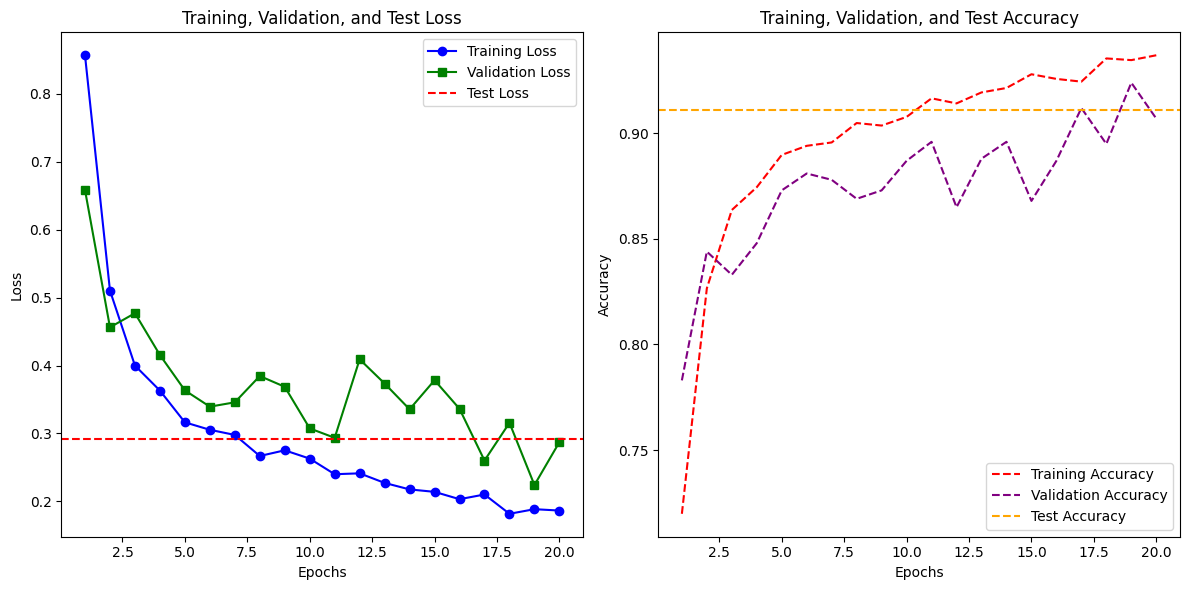

In [52]:
# accuracy and loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
test_loss = test_loss  # Replace test_loss with the actual value
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
test_accuracy = test_accuracy  # Replace test_accuracy with the actual value
epochs = range(1, len(train_loss) + 1)  # Epoch numbers
# Create a figure with two subplots
import matplotlib.pyplot as plt
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Plot training, validation, and test loss on the left side
ax1.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
ax1.plot(epochs, val_loss, label='Validation Loss', color='green', marker='s')
ax1.axhline(y=test_loss, color='red', linestyle='--', label='Test Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training, Validation, and Test Loss')
ax1.legend(loc='upper right')
# Plot training, validation, and test accuracy on the right side
ax2.plot(epochs, train_accuracy, label='Training Accuracy', color='red', linestyle='--')
ax2.plot(epochs, val_accuracy, label='Validation Accuracy', color='purple', linestyle='--')
ax2.axhline(y=test_accuracy, color='orange', linestyle='--', label='Test Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training, Validation, and Test Accuracy')
ax2.legend(loc='lower right')  # Add legend for accuracy plot
plt.tight_layout()  # Optional: adjust subplots to prevent overlap
plt.show()

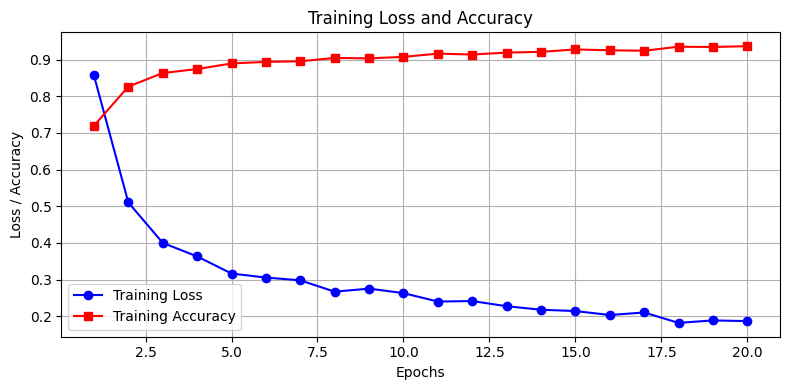

In [64]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
epochs = range(1, len(train_loss) + 1)
# Create a figure
plt.figure(figsize=(8, 4))
# Plot training loss
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss and Accuracy')
plt.legend()
# Plot training accuracy on the same graph
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='red', marker='s')
plt.ylabel('Loss / Accuracy')  # Shared y-axis label
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


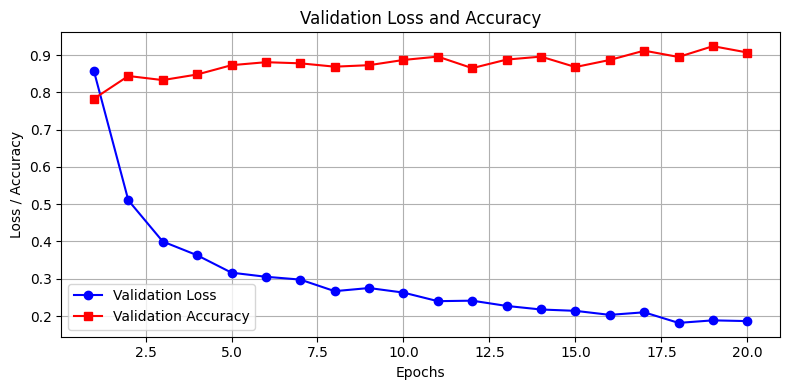

In [66]:
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(val_loss) + 1)
# Create a figure
plt.figure(figsize=(8,4))
# Plot training loss
plt.plot(epochs, train_loss, label='Validation Loss', color='blue', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss and Accuracy')
plt.legend()
# Plot training accuracy on the same graph
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red', marker='s')
plt.ylabel('Loss / Accuracy')  # Shared y-axis label
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

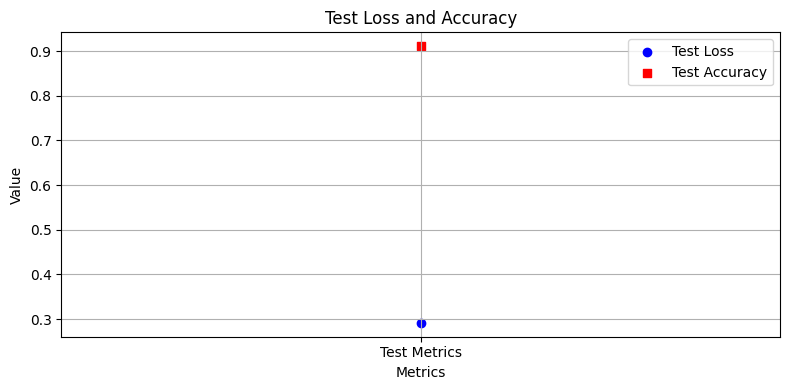

In [72]:
#  evaluated your model and obtained test_loss and test_accuracy
# Create a figure
plt.figure(figsize=(8, 4))
# Plot test loss as a single point
plt.scatter(1, test_loss, label='Test Loss', color='blue', marker='o')
# Plot test accuracy as a single point
plt.scatter(1, test_accuracy, label='Test Accuracy', color='red', marker='s')
plt.xticks([1], ['Test Metrics'])  # Customize x-axis tick label
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Test Loss and Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
# Evaluate the model on the test data
true_labels = test_generator.classes  # True labels for the test data
predicted_labels = model.predict(test_generator).argmax(axis=-1)  # Predicted labels for the test data
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f'Test Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

32/32 [==============================] - 19s 584ms/step
Test Accuracy: 0.903
Precision: 0.9056216062351012
Recall: 0.903
F1 Score: 0.9030618930342463


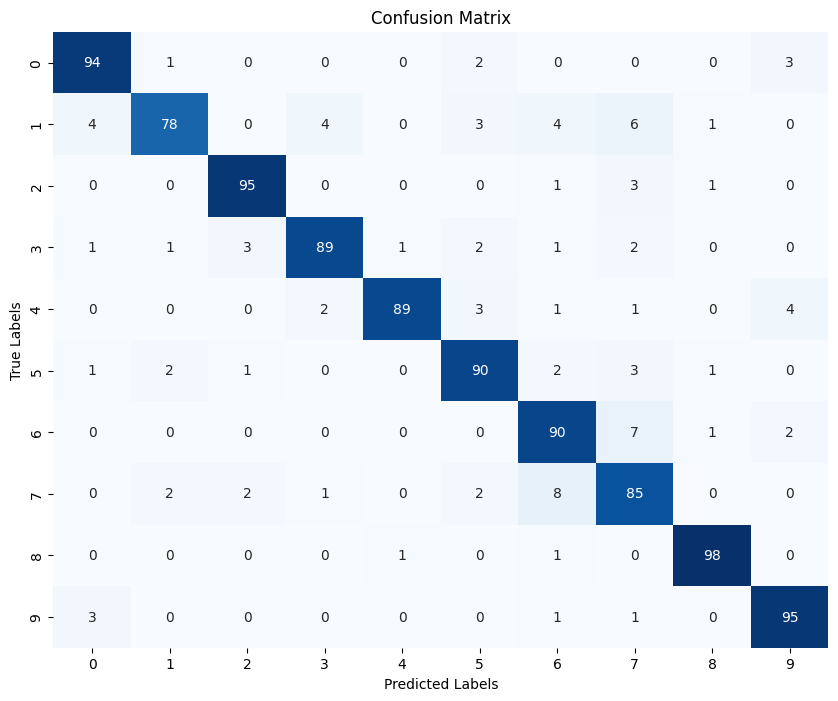

In [74]:
# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

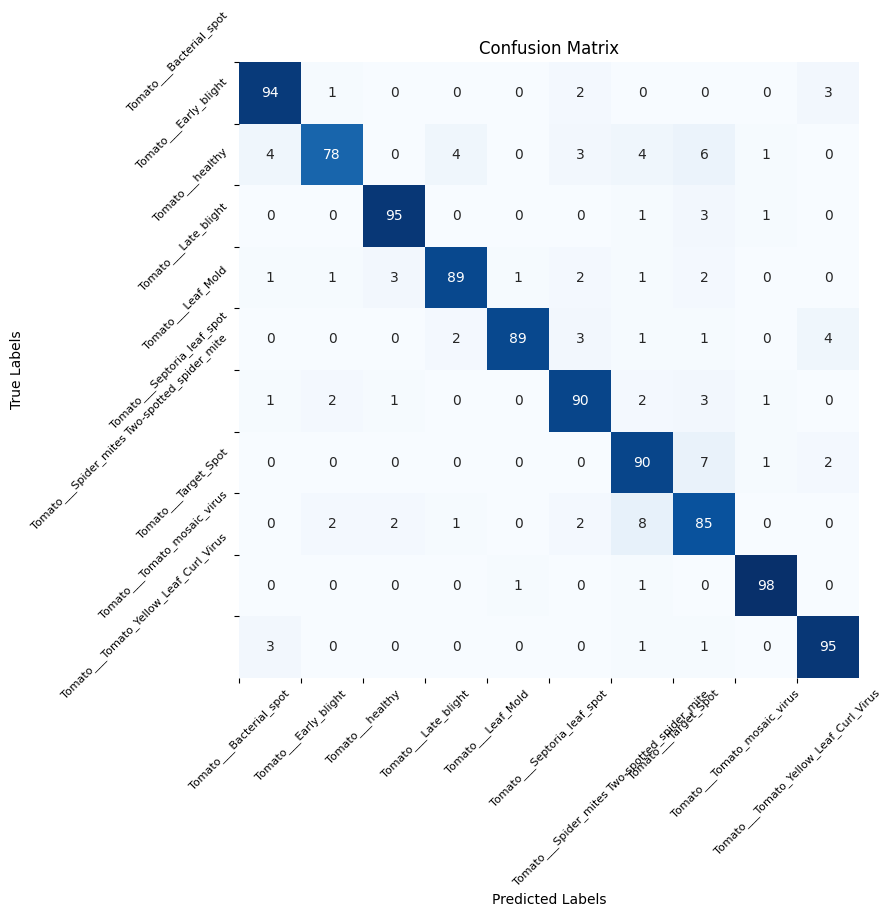

In [75]:
# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
class_labels=[
    'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy',
    'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
    'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
]
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
# Set x-axis and y-axis ticks with class labels
plt.xticks(ticks=range(len(class_labels)), labels=class_labels, fontsize=8, rotation=45)
plt.yticks(ticks=range(len(class_labels)), labels=class_labels, fontsize=8,rotation=45)
plt.show()

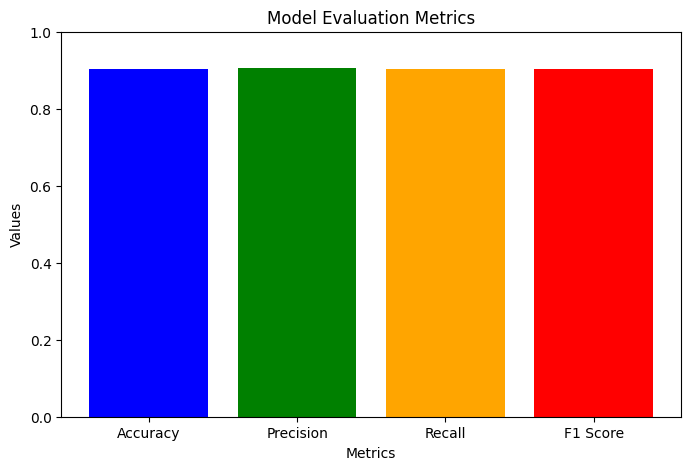

In [76]:
# Create bar graph for evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score',]
values = [accuracy, precision, recall, f1]
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Evaluation Metrics')
plt.ylim(0, 1)
plt.show()

In [77]:
model.save('/content/Final_model_tmt.h5')

In [78]:
print(os.path.exists('/content/Final_model_tmt.h5'))

True


In [ ]:
#at the time of running application to resolve the errors we need to do these times on the time of training(!!!optional)
#model.save('path_to_save_model', save_format='tf', include_optimizer=True)
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])